In [108]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

class change_detection_dataset(Dataset):
    def __init__(self,root_path) -> None:
        super().__init__()
        self.pre_change_path=os.path.join(root_path,"A")
        self.post_change_path=os.path.join(root_path,"B")
        self.change_label_path=os.path.join(root_path,"label")
        self.fname_list=os.listdir(self.pre_change_path)
    def __getitem__(self, index):
        fname=self.fname_list[index]
        pre_img=Image.open(os.path.join(self.pre_change_path,fname)).convert("RGB")
        post_img=Image.open(os.path.join(self.post_change_path,fname)).convert("RGB")
        change_label=Image.open(os.path.join(self.change_label_path,fname)).convert("1")
        transform=transforms.Compose([
            transforms.ToTensor()
        ])
        pre_tensor=transform(pre_img)
        post_tensor=transform(post_img)
        label_tensor=transform(change_label)
        return {'pre':pre_tensor,'post':post_tensor,'label':label_tensor,'fname':fname}
    def __len__(self):
        return len(self.fname_list)

In [109]:
train_path="D:\\Datasets\\Levir_croped_256\\LEVIR_CD\\train"
test_path="D:\\Datasets\\Levir_croped_256\\LEVIR_CD\\test"
val_path="D:\\Datasets\\Levir_croped_256\\LEVIR_CD\\val"

if __name__=="__main__":
    train_loader=DataLoader(change_detection_dataset(root_path=train_path),batch_size=8,shuffle=True,num_workers=0,pin_memory=False)
    test_loader=DataLoader(change_detection_dataset(root_path=test_path),batch_size=4,shuffle=False,num_workers=0,pin_memory=False)
    val_loader=DataLoader(change_detection_dataset(root_path=val_path),batch_size=4,shuffle=False,num_workers=0,pin_memory=False)

fname=train_5_14.png


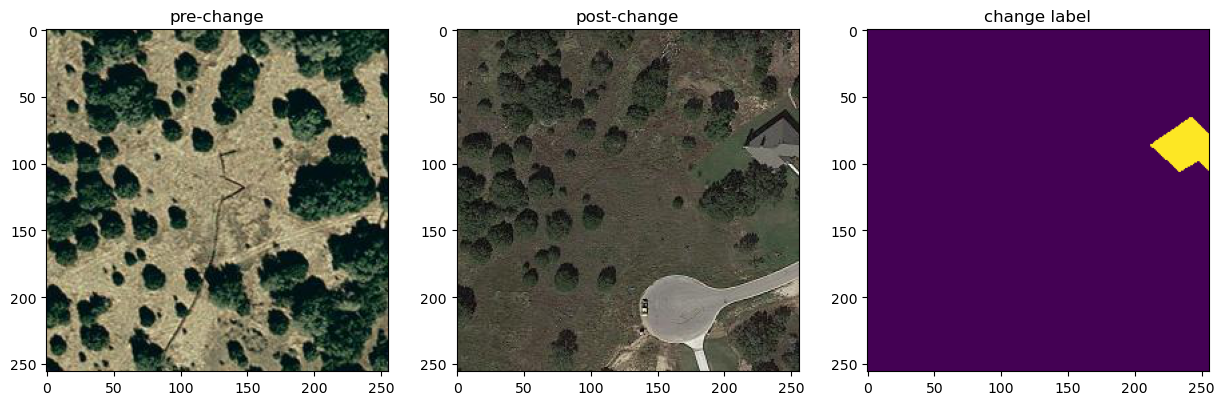

In [111]:
for i, data in enumerate(train_loader):
        pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
        fig=plt.figure(figsize=(15,5))

        preplot=fig.add_subplot(131)
        preplot.imshow(pre_tensor[1,:,:,:].permute(1,2,0).numpy())
        preplot.set_title("pre-change")

        postplot=fig.add_subplot(132)
        postplot.set_title("post-change")
        postplot.imshow(post_tensor[1,:,:,:].permute(1,2,0).numpy())

        labelplot=fig.add_subplot(133)
        labelplot.set_title("change label")
        labelplot.imshow(label_tensor[1,:,:,:].permute(1,2,0).numpy())
        # transforms.ToPILImage()(pre_tensor[0,:,:,:])
        # transforms.ToPILImage()(post_tensor[0,:,:,:])
        # transforms.ToPILImage()(label_tensor[0,:,:,:])
        print(f'fname={fname[0]}')
        break

In [112]:
################# Seeding the randomness  #################
import random

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
################## LOSS FUNCTION ##################

import torch.nn.functional as F

def dice_coef(y_true, y_pred, smooth=1, weight=0.5):
    y_true = y_true[:, :, :, -1]  # y_true[:, :, :, :-1]=y_true[:, :, :, -1] if dim(3)=1 等效于[8,256,256,1]==>[8,256,256]
    y_pred = y_pred[:, :, :, -1]
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + weight * torch.sum(y_pred)
    # K.mean((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
    return ((2. * intersection + smooth) / (union + smooth))                     # not working better using mean

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def weighted_bce_dice_loss(y_true,y_pred):
    class_loglosses = torch.mean(F.binary_cross_entropy(y_true, y_pred) )  #, axis=[0, 1, 2])

    class_weights = [0.1, 0.9]              #note that the weights can be computed automatically using the training smaples
    
    weighted_bce = torch.sum(class_loglosses * torch.tensor(class_weights))

    # return K.weighted_binary_crossentropy(y_true, y_pred,pos_weight) + 0.35 * (self.dice_coef_loss(y_true, y_pred)) #not work
    return weighted_bce + 0.5 * (dice_coef_loss(y_true, y_pred))


In [ ]:
#############Test the loss function

x=torch.rand(8,3,256,256)
y=torch.rand(8,3,256,256)

print(weighted_bce_dice_loss(x,y))

tensor(1.1675)


In [ ]:
# #################### MODEL ####################
# import torch.nn as nn

# class Standard_unit(nn.Module):
#     def __init__(self, input_tensor_dim, nb_filter, kernel_size=3, stride=1):
#         super(Standard_unit, self).__init__()

#         self.conv1 = nn.Conv2d(input_tensor_dim, nb_filter, kernel_size, stride=stride, padding='same')
#         nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='selu') # Initialize weights using He Normal initialization
#         self.selu1 = nn.SELU()
#         self.bn1 = nn.BatchNorm2d(nb_filter)

#         self.conv2 = nn.Conv2d(nb_filter, nb_filter, kernel_size, stride=stride, padding='same')
#         nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='selu') # Initialize weights using He Normal initialization
#         self.selu2 = nn.SELU()
#         self.bn2 = nn.BatchNorm2d(nb_filter)



#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.selu1(x)
#         x0 = x
#         x = self.bn1(x)
#         x = self.conv2(x)
#         x = self.selu2(x)
#         x = self.bn2(x)
#         x = x + x0
#         print (self.conv1.weight)
#         return x
    


In [ ]:
# ############# Test Model ##############

# x=torch.rand(8,3,256,256)
# model=Standard_unit(3,64)
# print(model(x).shape)


Parameter containing:
tensor([[[[ 0.1471,  0.1087, -0.1912],
          [-0.0306,  0.1482, -0.0526],
          [-0.1382, -0.0668,  0.3322]],

         [[ 0.2079,  0.1408,  0.0341],
          [ 0.2744,  0.0780,  0.0234],
          [-0.0720,  0.0070,  0.0701]],

         [[-0.1345, -0.1089,  0.0285],
          [ 0.0381, -0.0876, -0.2915],
          [-0.1873, -0.1943,  0.0455]]],


        [[[ 0.2360,  0.0394,  0.0579],
          [-0.0347, -0.1767, -0.0624],
          [-0.0805, -0.1975, -0.0207]],

         [[ 0.2198, -0.0517, -0.0838],
          [-0.2349, -0.2947, -0.1211],
          [ 0.0349, -0.0376, -0.0256]],

         [[-0.0020, -0.0780, -0.0839],
          [ 0.0944, -0.0785,  0.4362],
          [ 0.0924, -0.2703, -0.1344]]],


        [[[ 0.0517, -0.0461,  0.2600],
          [ 0.1394,  0.1679,  0.1165],
          [ 0.1053,  0.1293, -0.0098]],

         [[-0.2194,  0.1872,  0.2536],
          [ 0.1662,  0.0237, -0.2427],
          [ 0.0262,  0.1063,  0.2579]],

         [[ 0.0605,  0

In [132]:
import torch
import torch.nn as nn


class Standard_unit(nn.Module):
    def __init__(self, input_tensor_dim, nb_filter, kernel_size=3, stride=1):
        super(Standard_unit, self).__init__()

        self.conv1 = nn.Conv2d(input_tensor_dim, nb_filter, kernel_size, stride=stride, padding='same')
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='selu') # Initialize weights using He Normal initialization
        self.selu1 = nn.SELU()
        # self.dropout1 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm2d(nb_filter)

        self.conv2 = nn.Conv2d(nb_filter, nb_filter, kernel_size, stride=stride, padding='same')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='selu') # Initialize weights using He Normal initialization
        self.selu2 = nn.SELU()
        # self.dropout2 = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm2d(nb_filter)

    def forward(self, x):
        x = self.conv1(x)
        x = self.selu1(x)
        x0 = x
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.selu2(x)
        x = self.bn2(x)
        x = x + x0
        return x             #8, 64, 256, 256
    

class Nest_Net2(nn.Module):
    def __init__(self, channels=6 , filters = [32, 64, 128, 256, 512],  deep_supervision=False):
        super(Nest_Net2, self).__init__()

        # self.nb_filter = [32, 64, 128, 256, 512]
        self.filters = filters
        self.channels = channels
        
        self.conv1_1 = Standard_unit(channels, self.filters[0])                                      # (?,256,256, 32)
        self.pool1 = nn.MaxPool2d((2, 2), stride=(2, 2))                                             # (?,128,128, 32)

        self.conv2_1 = Standard_unit(self.filters[0], self.filters[1])                               # (?,128,128, 64)
        self.pool2 = nn.MaxPool2d(2, stride=2)                                                       # (?, 64, 64, 64)

        self.up1_2 = nn.ConvTranspose2d(self.filters[1], self.filters[0], kernel_size=2, stride=2, padding=0)                  # (?,256,256, 32)
        self.conv1_2 = Standard_unit(self.filters[1], self.filters[0])                                                         # (?,256,256, 32)

##########
        self.conv3_1 = Standard_unit(self.filters[1], self.filters[2])                               # (?, 64, 64, 128)
        self.pool3 = nn.MaxPool2d((2, 2), stride=(2, 2))                                             # (?, 32, 32 ,128)

        self.up2_2 = nn.ConvTranspose2d(self.filters[2], self.filters[1], kernel_size=2, stride=2, padding=0)                  # (?,128,128, 64)
        self.conv2_2 = Standard_unit(self.filters[2], self.filters[1])                                                         # (?,128,128, 64)

        self.up1_3 = nn.ConvTranspose2d(self.filters[1], self.filters[0], kernel_size=2, stride=2, padding=0)                  # (?,256,256, 32)
        self.conv1_3 = Standard_unit(self.filters[1]+self.filters[0], self.filters[0])                                         # (?,256,256, 32)

###########
        self.conv4_1 = Standard_unit(self.filters[2], self.filters[3])                                # (?,32,32, 256)
        self.pool4 = nn.MaxPool2d((2, 2), stride=(2, 2))                                              # (?,16,16, 256)

        self.up3_2 = nn.ConvTranspose2d(self.filters[3], self.filters[2], kernel_size=2, stride=2, padding=0)                    # (?,64,64, 128)
        self.conv3_2 = Standard_unit(self.filters[3], self.filters[2])                                                           # (?,64,64, 128)

        self.up2_3 = nn.ConvTranspose2d(self.filters[2], self.filters[1], kernel_size=2, stride=2, padding=0)                    # (?,128,128, 64)
        self.conv2_3 = Standard_unit(self.filters[2]+self.filters[1], self.filters[1])                                           # (?,128,128, 64)

        self.up1_4 = nn.ConvTranspose2d(self.filters[1], self.filters[0], kernel_size=2, stride=2, padding=0)                    # (?,256, 256, 32)
        self.conv1_4 = Standard_unit(self.filters[2], self.filters[0])                                                           # (?,256, 256, 32)

###########
        self.conv5_1 = Standard_unit(self.filters[3], self.filters[4])                                 # (?,16,16, 512)

        self.up4_2 = nn.ConvTranspose2d(self.filters[4], self.filters[3], kernel_size=2, stride=2, padding=0)                    # (?,32,32, 256)
        self.conv4_2 = Standard_unit(self.filters[4], self.filters[3])                                                           # (?,32,32, 256)

        self.up3_3 = nn.ConvTranspose2d(self.filters[3], self.filters[2], kernel_size=2, stride=2, padding=0)                    # (?,64,64, 128)
        self.conv3_3 = Standard_unit(self.filters[3]+self.filters[2], self.filters[2])                                           # (?,64,64, 128)

        self.up2_4 = nn.ConvTranspose2d(self.filters[2], self.filters[1], kernel_size=2, stride=2, padding=0)                    # (?,128,128, 64)
        self.conv2_4 = Standard_unit(self.filters[2]+self.filters[2], self.filters[1])                                           # (?,128,128, 64)

        self.up1_5 = nn.ConvTranspose2d(self.filters[1], self.filters[0], kernel_size=2, stride=2, padding=0)                    # (?,256, 256, 32)
        self.conv1_5 = Standard_unit(self.filters[1]+self.filters[1]+self.filters[0], self.filters[0])                           # (?,256, 256, 32)

###########
        # nestnet_output_1 = nn.Conv2d(self.filters[0], 1, kernel_size=1, activation='sigmoid', name='output_1')                       
        self.nestnet_output_1 = nn.Conv2d(self.filters[0], 1, kernel_size=1, padding='same')                       # (?,256,256, 1)
        self.nestnet_output_2 = nn.Conv2d(self.filters[0], 1, kernel_size=1, padding='same')                       # (?,256,256, 1)
        self.nestnet_output_3 = nn.Conv2d(self.filters[0], 1, kernel_size=1, padding='same')                       # (?,256,256, 1)
        self.nestnet_output_4 = nn.Conv2d(self.filters[0], 1, kernel_size=1, padding='same')                       # (?,256,256, 1)

        nn.init.kaiming_normal_(self.nestnet_output_1.weight, mode='fan_in', nonlinearity='selu') # Initialize weights using He Normal initialization
        nn.init.kaiming_normal_(self.nestnet_output_2.weight, mode='fan_in', nonlinearity='selu') # Initialize weights using He Normal initialization
        nn.init.kaiming_normal_(self.nestnet_output_3.weight, mode='fan_in', nonlinearity='selu') # Initialize weights using He Normal initialization
        nn.init.kaiming_normal_(self.nestnet_output_4.weight, mode='fan_in', nonlinearity='selu') # Initialize weights using He Normal initialization

        # conv_fuse = torch.cat([nestnet_output_1, nestnet_output_2, nestnet_output_3, nestnet_output_4], name='merge_output', axis=bn_axis)          # (?,256,256, 4)
        self.nestnet_output_5 = nn.Conv2d(4, 1, kernel_size=1, padding='same')                                      # (?,256,256, 1)
        
        nn.init.kaiming_normal_(self.nestnet_output_5.weight, mode='fan_in', nonlinearity='selu') # Initialize weights using He Normal initialization

        
    
    def forward(self, m,n):
        x = torch.cat([m, n], axis=1)                                                           # (?,256,256, 6)
        # print (x.shape)
        x1_1 = self.conv1_1(x)                                                                  # (?,256,256, 32)
        # print ("x1_1:  " ,x1_1.shape)
        x2_1 = self.conv2_1(self.pool1(x1_1))                                                   # (?,128,128, 64)
        # print ("x2_1 shape:   " , x2_1.shape)
        x1_2 = self.conv1_2(torch.cat([self.up1_2(x2_1), x1_1], axis=1))                        # (?,256,256, 32)
        # print ("x1_2 after Conv1_2: " , x1_2.shape)      
        x3_1 = self.conv3_1(self.pool2(x2_1) )                                                  # (?,64,64, 128)
        # print ("x3_1 after conv3_1 shape:   " , x3_1.shape)
        
        
        x2_2 = self.conv2_2(torch.cat([self.up2_2(x3_1), x2_1], axis=1))                        # (?,128,128, 64)
        x1_3 = self.conv1_3(torch.cat([self.up1_3(x2_2), x1_2, x1_1], axis=1))                  # (?,256,256, 32)

        x4_1 = self.conv4_1(self.pool3(x3_1))                                                   # (?,32,32, 256)
        x3_2 = self.conv3_2(torch.cat([self.up3_2(x4_1), x3_1], axis=1))                        # (?,64,64, 128)
        x2_3 = self.conv2_3(torch.cat([self.up2_3(x3_2), x2_2, x2_1], axis=1))                  # (?,128,128, 64)
        x1_4 = self.conv1_4(torch.cat([self.up1_4(x2_3), x1_3, x1_2, x1_1], axis=1))            # (?,256,256, 32)

        x5_1 = self.conv5_1(self.pool4(x4_1))                                                   # (?,16,16, 512)
        x4_2 = self.conv4_2(torch.cat([self.up4_2(x5_1), x4_1], axis=1))                        # (?,32,32, 256)
        x3_3 = self.conv3_3(torch.cat([self.up3_3(x4_2), x3_2, x3_1], axis=1))                  # (?,64,64, 128)
        x2_4 = self.conv2_4(torch.cat([self.up2_4(x3_3), x2_3, x2_2, x2_1], axis=1))            # (?,128,128, 64)

        # print (x2_4.shape)
        # print (x1_4.shape, x1_3.shape, x1_2.shape, x1_1.shape)
        
        x1_5 = self.conv1_5(torch.cat([self.up1_5(x2_4), x1_4, x1_3, x1_2, x1_1], axis=1))  # (?,256,256, 32)

        output_1 = torch.sigmoid(self.nestnet_output_1(x1_2))                                  # (?,256,256, 1)
        output_2 = torch.sigmoid(self.nestnet_output_2(x1_3))                                  # (?,256,256, 1)
        output_3 = torch.sigmoid(self.nestnet_output_3(x1_4))                                  # (?,256,256, 1)
        output_4 = torch.sigmoid(self.nestnet_output_4(x1_5))                                  # (?,256,256, 1)
        conv_fuse = torch.cat([output_1, output_2, output_3, output_4], axis=1)             # (?,256,256, 4)
        output_5 = torch.sigmoid(self.nestnet_output_5(conv_fuse))                             # (?,256,256, 1)

        return output_4
    

if __name__=="__main__":
    m=torch.rand(8,3,256,256)
    n=torch.rand(8,3,256,256)
    model=Nest_Net2()
    print(model(m,n).shape)



torch.Size([8, 1, 256, 256])


In [133]:
def train(model, train_loader, val_loader, optimizer, loss_function, device, num_epochs, save_path):
    for epoch in range(num_epochs):
        loss_list=[]
        model.train()
        for _, data in enumerate(train_loader):
            optimizer.zero_grad()
            pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
            pre_tensor = pre_tensor.to(device)
            post_tensor = post_tensor.to(device)
            label_tensor = label_tensor.to(device)
            prediction = model(pre_tensor, post_tensor)
            total_loss=loss_function(prediction,label_tensor)
            loss_list.append(total_loss.item()) #only append the loss value and ignore the grad to save memory
            total_loss.backward()
            optimizer.step()
        loss_avg=sum(loss_list)/len(loss_list)
        print(f'Epoch {epoch} training completed, the average loss is {loss_avg}.')

        if (epoch+1) % 10==0:
            model.eval()
            OA_list=[]
            for _, data in enumerate(val_loader):
                pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
                pre_tensor = pre_tensor.to(device)
                post_tensor = post_tensor.to(device)
                label_tensor = label_tensor.to(device)
                probs = model(pre_tensor, post_tensor)
                prediction = torch.where(probs>0.5,1,0)
                true_count=torch.sum(prediction==label_tensor)
                OA=true_count/prediction.numel()
                OA_list.append(OA)
            print("*"*10)
            print(f'Epoch {epoch} evaluation completed, the average OA is {sum(OA_list)/len(OA_list)}')
            print("*"*10)
            torch.save(model.state_dict(),os.path.join(save_path,"ResUnet"+str(epoch)+".pth"))

In [134]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)
model=model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
loss_function=torch.nn.BCELoss()
num_epochs=30
save_path="E://VS Projects//test_9-1-2025_UNet++//checkpoint1"
os.makedirs(save_path, exist_ok=True)
train(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs=num_epochs, save_path=save_path)

cuda
Epoch 0 training completed, the average loss is 0.24906489171553403.
Epoch 1 training completed, the average loss is 0.05501232482492924.
Epoch 2 training completed, the average loss is 0.046965920948423445.
Epoch 3 training completed, the average loss is 0.0396107948909048.
Epoch 4 training completed, the average loss is 0.03223835185053758.
Epoch 5 training completed, the average loss is 0.030132344822050072.
Epoch 6 training completed, the average loss is 0.02663231364567764.
Epoch 7 training completed, the average loss is 0.02698627856443636.
Epoch 8 training completed, the average loss is 0.022152463308884762.
Epoch 9 training completed, the average loss is 0.022980362249654718.
**********
Epoch 9 evaluation completed, the average OA is 0.9775863885879517
**********
Epoch 10 training completed, the average loss is 0.020464797591557726.
Epoch 11 training completed, the average loss is 0.016215545663726516.
Epoch 12 training completed, the average loss is 0.022011779044987634.


In [116]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [135]:
from torchvision.utils import save_image

model = Nest_Net2()
model=model.to(device)
model.load_state_dict(torch.load("E://VS Projects//test_9-1-2025_UNet++//checkpoint1//ResUnet29.pth"))

test_results_path="E://VS Projects//test_9-1-2025_UNet++//test_results1"
os.makedirs(test_results_path,exist_ok=True)
TP=0
TN=0
FP=0
FN=0
for _, data in enumerate(test_loader):
    pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
    pre_tensor = pre_tensor.to(device)
    post_tensor = post_tensor.to(device)
    label_tensor = label_tensor.to(device)
    probs = model(pre_tensor, post_tensor)
    prediction = torch.where(probs>0.5,1.0,0.0)
    true_positives, false_positives, true_negatives, false_negatives = confusion(prediction,label_tensor)
    TP+=true_positives
    TN+=true_negatives
    FP+=false_positives
    FN+=false_negatives
    for i in range(prediction.shape[0]):
        save_image(prediction[i,:,:,:].cpu(), os.path.join(test_results_path, fname[i]))

C:\Users\G7\AppData\Local\Temp\ipykernel_196\1562477466.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("E://VS Projects//test_9-1-2025_

fname=test_8_6.png


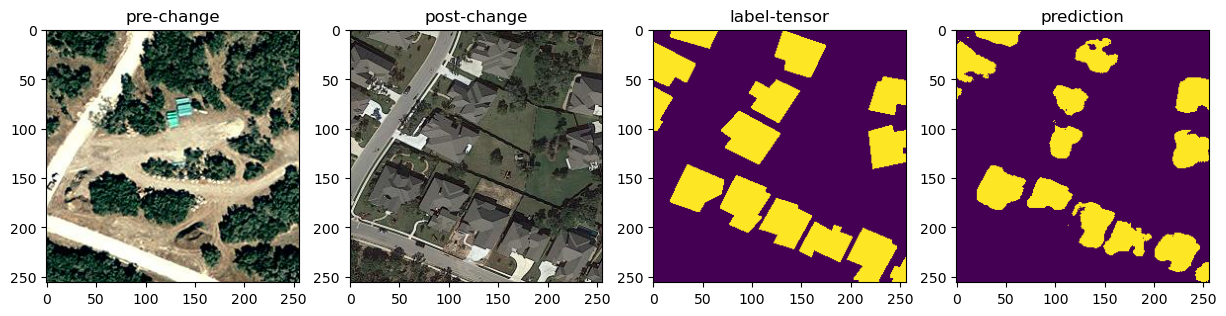

In [136]:
import matplotlib.pyplot as plt
import numpy as np

pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
fig=plt.figure(figsize=(15,5))

preplot=fig.add_subplot(141)
preplot.imshow(pre_tensor[1,:,:,:].permute(1,2,0).numpy())
preplot.set_title("pre-change")

postplot=fig.add_subplot(142)
postplot.set_title("post-change")
postplot.imshow(post_tensor[1,:,:,:].permute(1,2,0).numpy())

postplot=fig.add_subplot(143)
postplot.set_title("label-tensor")
postplot.imshow(label_tensor[1,:,:,:].permute(1,2,0).numpy())

labelplot=fig.add_subplot(144)
labelplot.set_title("prediction")
labelplot.imshow(prediction[1,:,:,:].permute(1,2,0).cpu().numpy())
# transforms.ToPILImage()(pre_tensor[0,:,:,:])
# transforms.ToPILImage()(post_tensor[0,:,:,:])
# transforms.ToPILImage()(label_tensor[0,:,:,:])
print(f'fname={fname[0]}')

In [138]:
OA=(TP+TN)/(TP+TN+FP+FN)
Precision=TP/(TP+FP)
Recall=TP/(TP+FN)
F1_score=2*Precision*Recall/(Precision+Recall)

print(f'OA={OA:.3f}, Precision={Precision:.3f}, Recall={Recall:.3f}, F1-score={F1_score:.3f}')
# print(f'OA={OA:.3f},  Recall={Recall:.3f}')

OA=0.986, Precision=0.893, Recall=0.697, F1-score=0.783


In [131]:
import torchinfo
torchinfo.summary(model, input_size=[(8,3,256,256),(8,3,256,256)], device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Nest_Net2                                [8, 1, 256, 256]          --
├─Standard_unit: 1-1                     [8, 32, 256, 256]         --
│    └─Conv2d: 2-1                       [8, 32, 256, 256]         1,760
│    └─SELU: 2-2                         [8, 32, 256, 256]         --
│    └─BatchNorm2d: 2-3                  [8, 32, 256, 256]         64
│    └─Conv2d: 2-4                       [8, 32, 256, 256]         9,248
│    └─SELU: 2-5                         [8, 32, 256, 256]         --
│    └─BatchNorm2d: 2-6                  [8, 32, 256, 256]         64
├─MaxPool2d: 1-2                         [8, 32, 128, 128]         --
├─Standard_unit: 1-3                     [8, 64, 128, 128]         --
│    └─Conv2d: 2-7                       [8, 64, 128, 128]         18,496
│    └─SELU: 2-8                         [8, 64, 128, 128]         --
│    └─BatchNorm2d: 2-9                  [8, 64, 128, 128]         128
│   